# **How do popular ETFs compare in returns, volatility, and fees?**

In [24]:
!pip install yfinance

In [25]:
# Download packages
import yfinance as yf
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from datetime import datetime, timedelta


Decide on ETFs you want to compare

In [26]:
# Configuration of ETS you want to use
ETFS = ["VEU", "VOO", "VTI", "QQQ"]

### **What are the ETFs comprised of?**

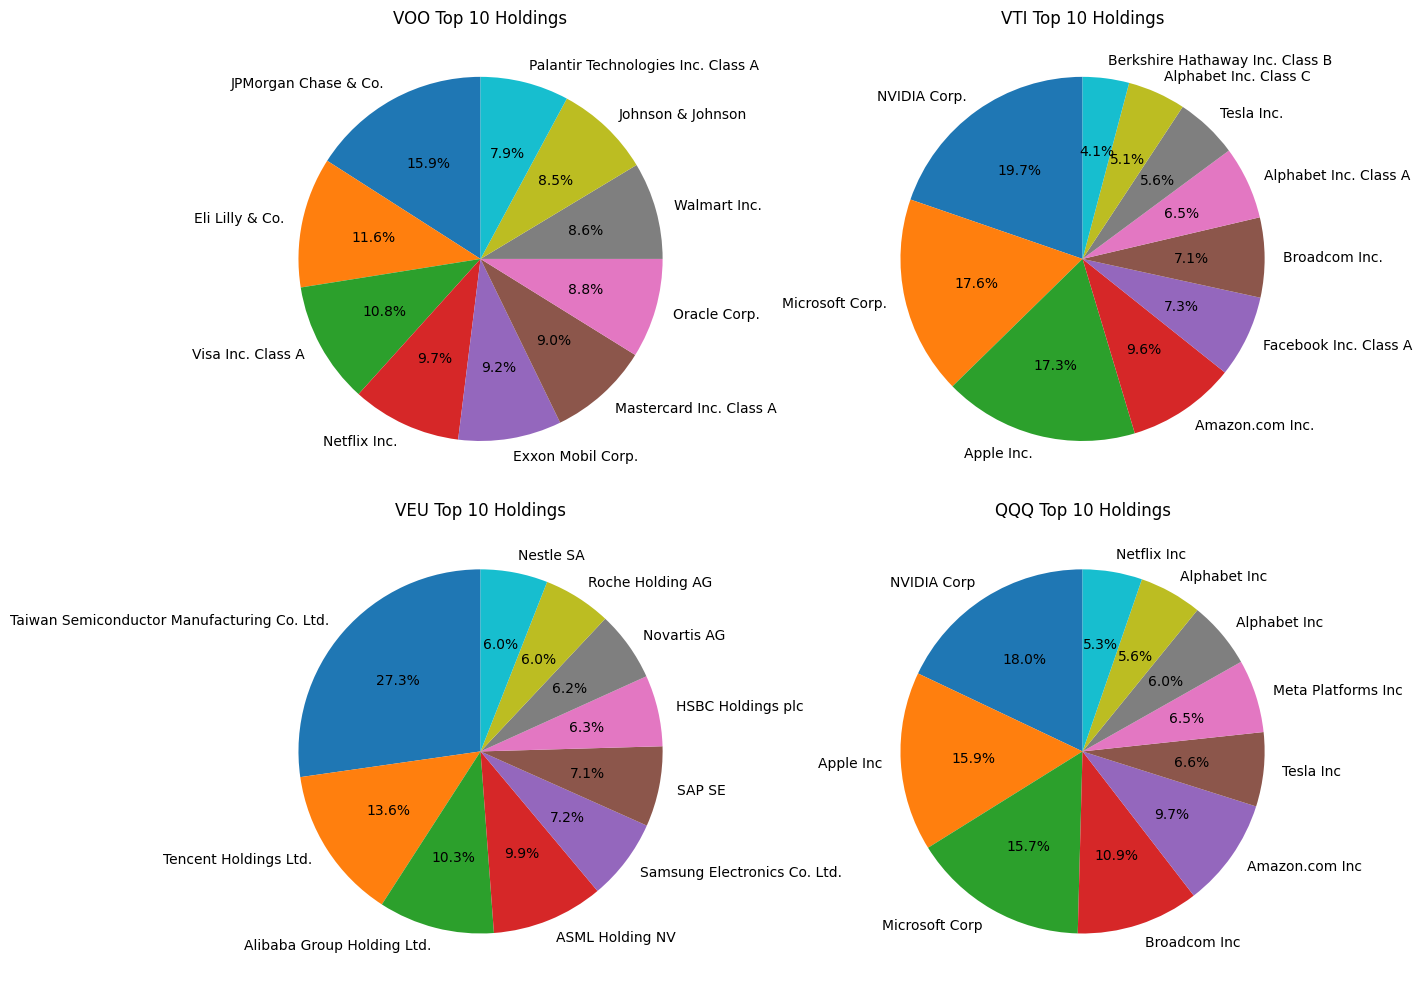

In [27]:
filenames = ["VOO.csv", "VTI.csv", "VEU.csv", "QQQ.csv"]

#dictionary to store data
etfs_data = {}

for filename in filenames:
    df = pd.read_csv(filename)

    # Clean column names
    df.columns = df.columns.str.strip()

    df['Weight (%)'] = df['% of fund']

    # Keep top 10 holdings only
    df_top10 = df.head(10)
    etf_name = filename.split('.')[0].upper()
    etfs_data[etf_name] = df_top10


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, (etf, data) in zip(axes, etfs_data.items()):
    labels = data['Holdings']
    sizes = data['Weight (%)']
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    ax.set_title(f"{etf} Top 10 Holdings")

plt.tight_layout()
plt.show()

### **What sectors make up each ETF?**

#### QQQ:

In [28]:
URL = 'https://www.invesco.com/qqq-etf/en/about.html?utm_campaign=INV_QQQ_2025_Google_Search_US_CoreQQQ_Brand_x_Prospecting_1869113&utm_source=Google&utm_medium=cpc&utm_content=qqq-cpc-paid-text&utm_term=21747614533_167110092919&gclsrc=aw.ds&gad_source=1&gad_campaignid=21747614533&gbraid=0AAAAABqAFo_zXB-ukN6PTXvNC8wMHAd-m&gclid=CjwKCAjwgeLHBhBuEiwAL5gNEbjP19EAXQ7SnppJ61rR0krC25Z6w9Tdd-lBUOqT7nWDo_ZGUibZshoCDCUQAvD_BwE'

In [29]:
response = requests.get(URL)

soup = BeautifulSoup(response.text, 'html.parser')
sectors = []
allocations = []

list_container = soup.find('ul', class_='c-sector-allocation__chart-benchmarks')

In [30]:
all_list_items = list_container.find_all('li')

#Loop through them and filter out the header manually
for item in all_list_items:

    class_list = item.get('class', [])

    is_data_row = False
    prefix = 'c-sector-allocation__chart-benchmark-'

    for cls in class_list:
        if cls.startswith(prefix):
            #get the part after the prefix (which in this website are numbers determining the order of info)
            suffix = cls[len(prefix):]

            # If the suffix is all digits, it's a data row
            if suffix.isdigit():
                is_data_row = True
                break

    #if it's not a data row (then it's the header), skip it
    if not is_data_row:
        continue

    #we extract the data
    name_tag = item.find('span', class_='c-sector-allocation__chart-benchmark-name')
    value_tag = item.find('span', class_='c-sector-allocation__chart-benchmark-value')

    if name_tag and value_tag:
        sectors.append(name_tag.text.strip())
        allocations.append(value_tag.text.strip())

df = pd.DataFrame({
    'Sector': sectors,
    'Allocation': allocations
})
print(df)

                   Sector Allocation
0              Technology     64.03%
1  Consumer Discretionary     18.29%
2             Health Care      4.21%
3      Telecommunications      3.71%
4             Industrials      3.66%
5        Consumer Staples      2.39%
6         Basic Materials      1.49%
7               Utilities      1.37%
8                  Energy      0.48%
9             Real Estate      0.19%


In [31]:
df['Value'] = df['Allocation'].str.replace('%', '').astype(float)

#group all categories <2.4 into an 'other' caegory for a cleaner representation
threshold = 2.4

#Slices to keep
df_above = df[df['Value'] >= threshold].copy()
#Slices to group
df_below = df[df['Value'] < threshold].copy()

if not df_below.empty:
    #Sum all values below the threshold and store them in a new row called "other"
    other_sum = df_below['Value'].sum()

    other_row = pd.DataFrame({'Sector': [f'Other (< {threshold}%)'], 'Value': [other_sum]})

    df_plot = pd.concat([df_above, other_row], ignore_index=True)

df_plot = df_plot[['Sector', 'Value']].sort_values(by='Value', ascending=False)
print(df_plot)

                   Sector  Value
0              Technology  64.03
1  Consumer Discretionary  18.29
5          Other (< 2.4%)   5.92
2             Health Care   4.21
3      Telecommunications   3.71
4             Industrials   3.66


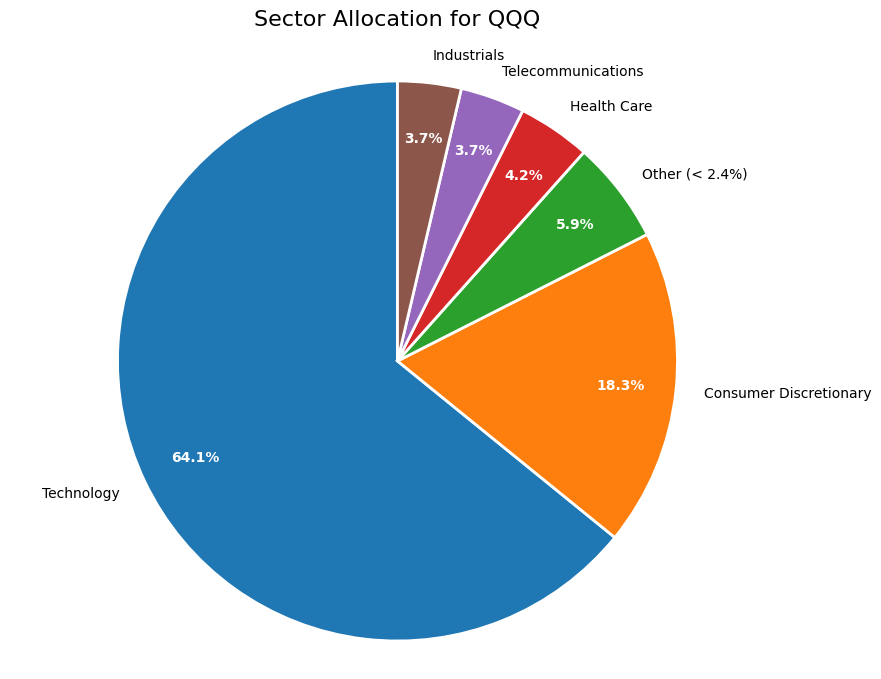

In [32]:
plt.figure(figsize=(10, 8))

#'edgecolor' adds a white line between slices
wedge_properties = {'edgecolor': 'white', 'linewidth': 2}

patches, texts, autotexts = plt.pie(
    df_plot['Value'],
    labels=df_plot['Sector'],
    autopct='%1.1f%%',         #Format to show percentages
    startangle=90,             #Start the first slice at the top (90 degrees)
    pctdistance=0.8,           #Move the percentage text inside the slices
    wedgeprops=wedge_properties
)

for text in autotexts:
    text.set_color('white')
    text.set_weight('bold')

plt.title('Sector Allocation for QQQ', fontsize=16, pad=20)

plt.axis('equal')

plt.show()

### VTI:

In [33]:
df_veu_regions = pd.read_csv('VEU_regions.csv')
df_voo_sectors = pd.read_csv('VOO_sectors.csv')
df_vti_sectors = pd.read_csv('VTI_sectors.csv')

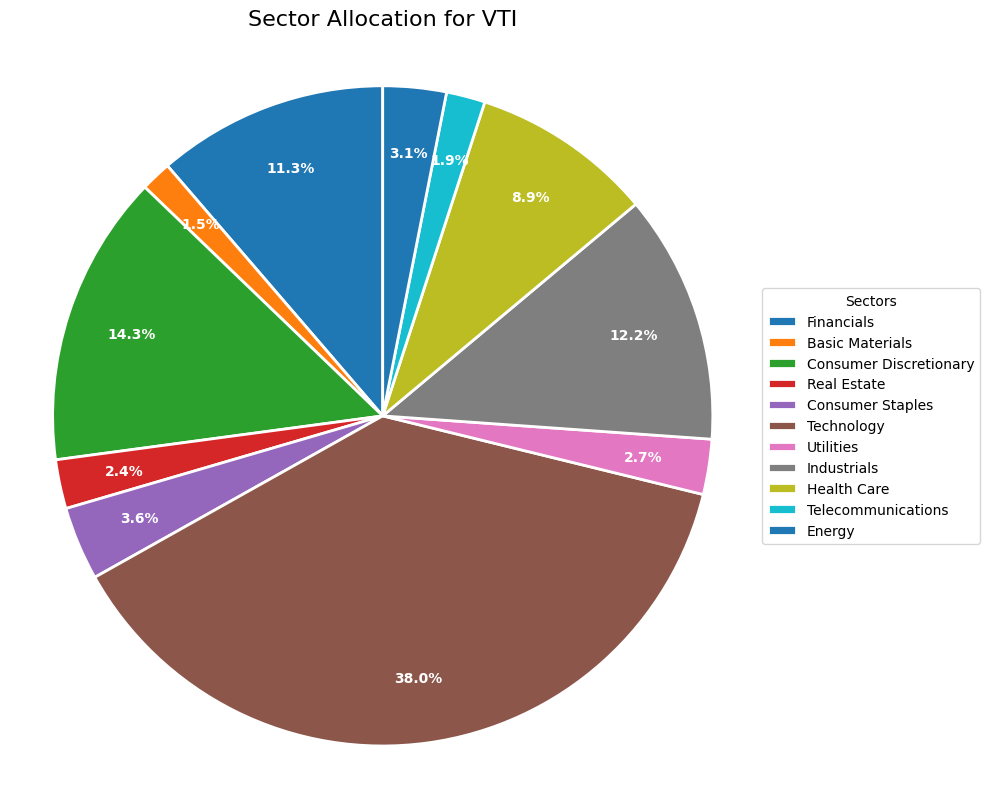

In [34]:
plt.figure(figsize=(10, 8))

#'edgecolor' adds a white line between slices
wedge_properties = {'edgecolor': 'white', 'linewidth': 2}

patches, texts, autotexts = plt.pie(
    df_vti_sectors['VTI'],
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.8,
    wedgeprops=wedge_properties
)


for text in autotexts:
    text.set_color('white')
    text.set_weight('bold')

plt.title('Sector Allocation for VTI', fontsize=16, pad=20)

plt.axis('equal')

plt.legend(
    patches,
    df_vti_sectors['Sectors'],
    title="Sectors",
    loc="center left",          # Position the legend
    bbox_to_anchor=(1, 0, 0.5, 1) # Place it outside the pie (to the right)
)

plt.tight_layout()
plt.show()

### VOO

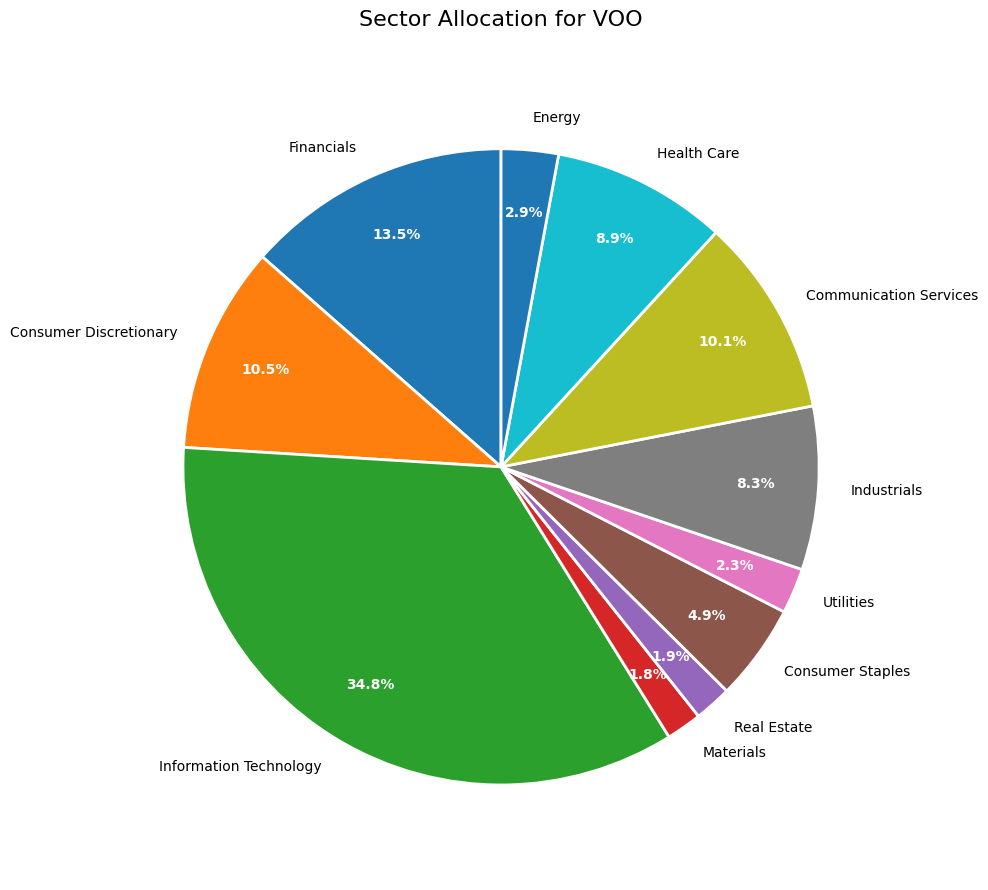

In [35]:
plt.figure(figsize=(10, 9))

#'edgecolor' adds a white line between slices
wedge_properties = {'edgecolor': 'white', 'linewidth': 2}

patches, texts, autotexts = plt.pie(
    df_voo_sectors['VOO(%)'],          #The numeric values
    labels=df_voo_sectors['Sectors'],
    autopct='%1.1f%%',         #Format to show percentages
    startangle=90,             #Start the first slice at the top (90 degrees)
    pctdistance=0.8,           #Move the percentage text inside the slices
    wedgeprops=wedge_properties
)

#Make the percentage text bold and white
for text in autotexts:
    text.set_color('white')
    text.set_weight('bold')

plt.title('Sector Allocation for VOO', fontsize=16, pad=20)

#ensures that the pie chart is a perfect circle
plt.axis('equal')

plt.tight_layout()
plt.show()

### **What regions does VEU cover?**

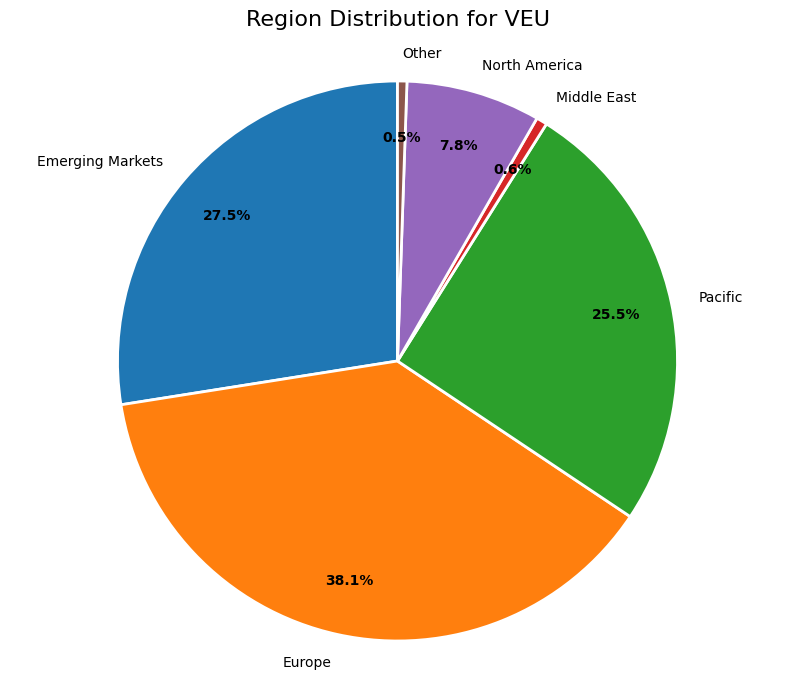

In [36]:
plt.figure(figsize=(10, 8))

wedge_properties = {'edgecolor': 'white', 'linewidth': 2}

patches, texts, autotexts = plt.pie(
    df_veu_regions['VEU'],          #The numeric values
    labels=df_veu_regions['Regions'],  #The sector names for labels
    autopct='%1.1f%%',         #Format to show percentages
    startangle=90,             #Start the first slice at the top (90 degrees)
    pctdistance=0.8,           #Move the percentage text inside the slices
    wedgeprops=wedge_properties #This applies the donut effect
)

#Make the percentage text bold and white
for text in autotexts:
    text.set_color('black')
    text.set_weight('bold')

plt.title('Region Distribution for VEU', fontsize=16, pad=20)

#ensures that the pie chart is a perfect circle
plt.axis('equal')

plt.show()

###**Download Dataset from yfinance**

Decide on time period. Replace start and end with your preferred time horizon

In [37]:
# last 10 years data
data = yf.download(
    tickers=ETFS,
    start="2015-01-01",
    end=datetime.today(),
    interval="1d"  #daily data
)

/tmp/ipython-input-1628810187.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  4 of 4 completed


In [38]:
close_prices = data["Close"]
close_prices.head()

Ticker,QQQ,VEU,VOO,VTI
Date,,,,
2015-01-02,94.906555,34.102493,156.158112,88.342415
2015-01-05,93.514374,33.349998,153.414551,86.824440
2015-01-06,92.260521,33.050472,151.906052,85.973724
2015-01-07,93.449844,33.415768,153.804169,86.999596
2015-01-08,95.238472,33.883316,156.506287,88.534233


### **Calculate Daily Percentage Returns**

Daily percentage returns are a more appropriate measure of ETFs performance. A price change is misleading because it doesn't reveal the magnitude of the movement relative to the investment's starting value

In [39]:
#Calculate daily percentage returns
#Drop na since there is no previous day for the first day, which renders an error in the percentage change formula
returns = close_prices.pct_change().dropna()
returns.head()

Ticker,QQQ,VEU,VOO,VTI
Date,,,,
2015-01-05,-0.014669,-0.022066,-0.017569,-0.017183
2015-01-06,-0.013408,-0.008981,-0.009833,-0.009798
2015-01-07,0.012891,0.011053,0.012495,0.011932
2015-01-08,0.019140,0.013992,0.017569,0.017640
2015-01-09,-0.006583,-0.005606,-0.008421,-0.008290


 Annualized return by taking the mean of the daily % change on returns above

In [40]:
# 252 is the assumption for number of trading days per year
annual_return = (1 + returns.mean())**252 - 1

In [41]:
# Annualized volatility
annual_vol = returns.std() * (252**0.5)

Create a data frame to visualise the annual return and volatility

In [42]:
# Create a consolidated data frame of annualized return & volatility
summary = pd.DataFrame({
    'Annual Return': annual_return,
    'Annual Volatility': annual_vol
}).sort_values('Annual Return', ascending=False)

#make it 2 decimal places and in percentage to see better
summary.style.format({
    'Annual Return': '{:.2%}',
    'Annual Volatility': '{:.2%}'
})

,Annual Return,Annual Volatility
Ticker,,
QQQ,21.77%,22.05%
VOO,15.44%,17.95%
VTI,14.92%,18.20%
VEU,8.88%,17.23%


### **Risk vs Return Scatter Plot**


/tmp/ipython-input-1073651165.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(summary['Annual Volatility'][i], summary['Annual Return'][i], etf)


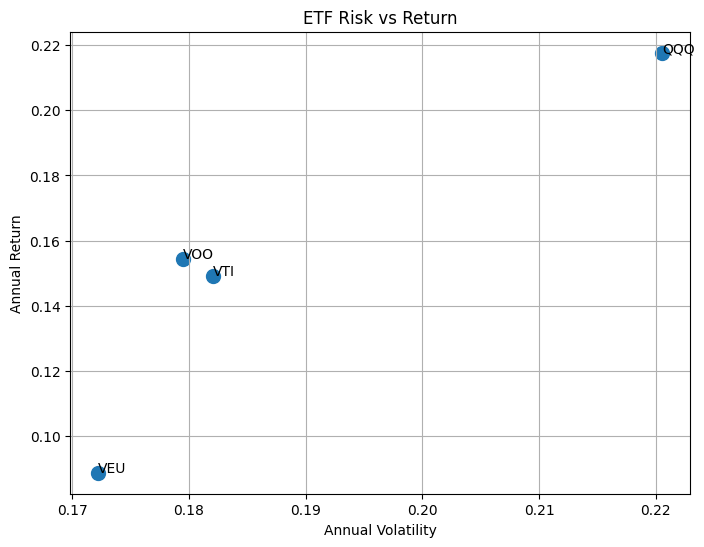

In [44]:
#Creating a Risk vs Return scatter plot
plt.figure(figsize=(8,6))
plt.scatter(
    summary['Annual Volatility'],
    summary['Annual Return'],
    s=100)
#Label each point
for i, etf in enumerate(summary.index):
    plt.text(summary['Annual Volatility'][i], summary['Annual Return'][i], etf)
plt.xlabel('Annual Volatility')
plt.ylabel('Annual Return')
plt.title('ETF Risk vs Return')
plt.grid(True)
plt.show()

QQQ has the highest annualized return and risk. This is a direct consequence of its 64% concentration in the high-growth (and high-volatility) technology sector.

VOO shows slightly better risk-adjusted returns than VTI in this period. VOO's focus on the 500 largest, most established companies was slightly more efficient than VTI, which also holds thousands of smaller, mid-cap, and small-cap stocks that may have slightly dragged on performance.

VEU’s low return is a well-known result of the U.S. market dramatically outperforming international markets over the last decade. Its lower volatility is a key feature of its diversification. It's spread across many countries and sectors (Healthcare, Financials, Consumer Goods, etc.) rather than being dominated by US tech.

It is important to note that this is just a 10-year window, which may not be representative of the time horizon and global circumstances in the future.

### **Annualized Volatility**

Rolling (21-day) volatility is the standard deviation of daily returns over each 21-day window, calculated again and again as you move one day forward each time. This is a smoother measure than say plotting daily averages over the same time period which would include many little spikes capturing day-sensitivities. We want trend-sensitivies.

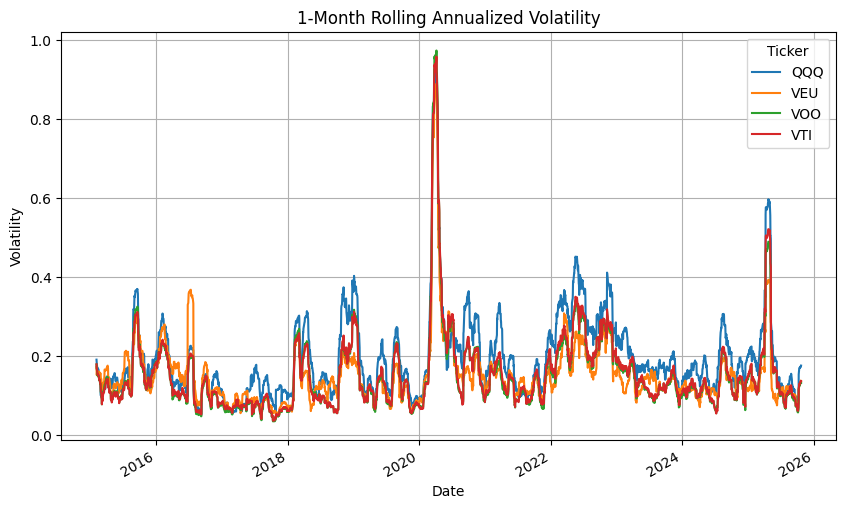

In [46]:
#how does risk change over time
#the window indicates to look at the last 21 daily returns (no. of trading days in each month) at each point

rolling_vol = returns.rolling(window=21).std() * (252**0.5)  # 21 trading days ≈ 1 month
rolling_vol.plot(figsize=(10,6))
plt.title('1-Month Rolling Annualized Volatility')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.grid(True)
plt.show()

The 1-Month Rolling Annualized Volatility graph illustrates how short-term market risk fluctuates over time.

QQQ consistently exhibits the highest volatility due to its tech concentration, while VEU (global ex-US) remains the least volatile, reflecting broader diversification and slower-moving international markets.

The extreme spike in early 2020 highlights how all ETFs experienced elevated risk during global shocks, though the magnitude and persistence differed by region and sector composition.

Rolling volatility is better at capturing short term risk while annualized volatility is better at capturing long term risk. What we did was capture short-term volatility, but scaling it to what it would be if that same level of volatility continued for a year.

### **Growth of Investment over 10 years**

Replace investment_amount with how much you want to invest. Gradients will be the same but helpful to see what values your investment could grow into

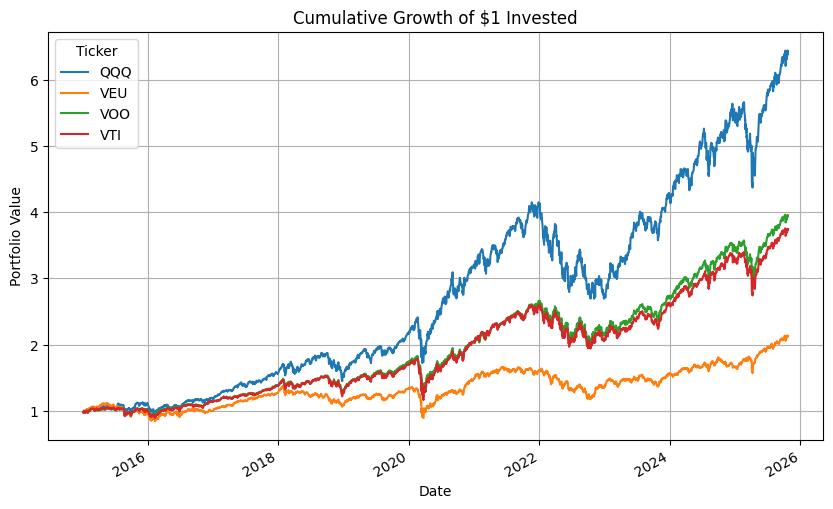

In [45]:
#Show how investment amount (in this case, $1) grows over time. You can also insert your preferred investment_amount
#cumulative returns using the returns variable which has the closing percentage changes
investment_amount = 1
cumulative = (1 + returns).cumprod()
cumulative = cumulative * investment_amount
cumulative.plot(figsize=(10,6))
plt.title(f'Cumulative Growth of ${investment_amount} Invested')
plt.ylabel('Portfolio Value')
plt.xlabel('Date')
plt.grid(True)
plt.show()

### **Expense Ratios**

Let's have a look at expense ratios to factor in annual fees charged by the fund

In [47]:
#tricky part here. you have to divide expense ratios by 100

fees = {ticker: yf.Ticker(ticker).info['netExpenseRatio']/100 for ticker in ETFS}
fees

{'VEU': 0.0004, 'VOO': 0.0003, 'VTI': 0.0003, 'QQQ': 0.002}

In [48]:
#Add Expense Ratio to summary data frame
summary['Expense Ratio'] = summary.index.map(fees)
summary.style.format({
    'Annual Return': '{:.2%}',
    'Annual Volatility': '{:.2%}',
    'Expense Ratio': '{:.2%}'
})

,Annual Return,Annual Volatility,Expense Ratio
Ticker,,,
QQQ,21.77%,22.05%,0.20%
VOO,15.44%,17.95%,0.03%
VTI,14.92%,18.20%,0.03%
VEU,8.88%,17.23%,0.04%


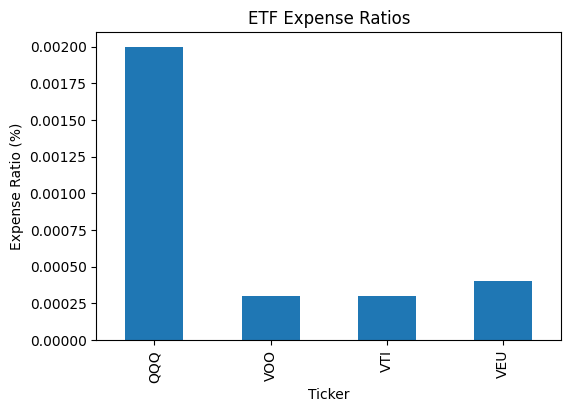

In [49]:
summary['Expense Ratio'].plot(kind='bar', figsize=(6,4))
plt.ylabel('Expense Ratio (%)')
plt.title('ETF Expense Ratios')
plt.show()


### **Dollar Loss Due to Expense Ratios**

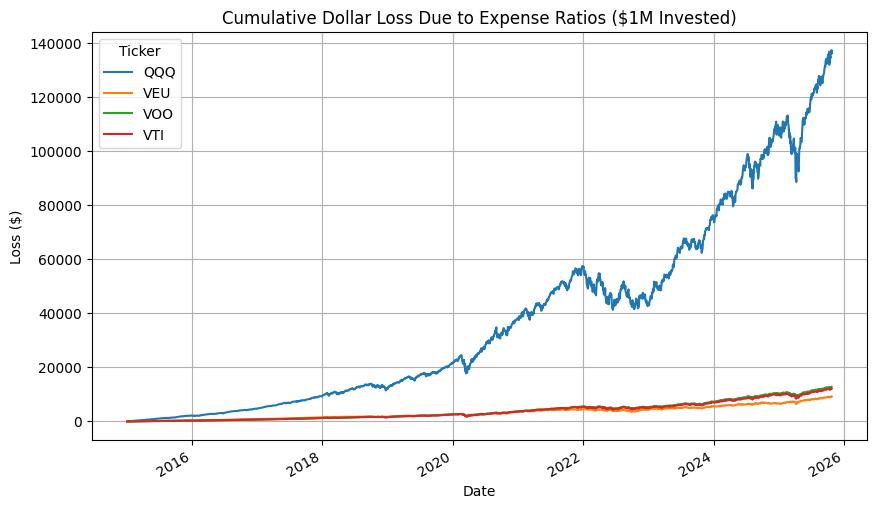

In [50]:
#Apply expense ratios to daily returns
daily_fees = pd.Series(fees) / 252  #convert annual to daily rate

daily_fees = daily_fees.reindex(returns.columns)
#Subtract the daily fee for each ETF
net_returns = returns - daily_fees

#Calculate cumulative net growth
investment_amount = 1000000 # edit here to see a different investment amount
cumulative_net = (1 + net_returns).cumprod()

fee_loss = (cumulative - cumulative_net) * investment_amount
fee_loss.plot(figsize=(10,6))
plt.title("Cumulative Dollar Loss Due to Expense Ratios ($1M Invested)")
plt.ylabel("Loss ($)")
plt.xlabel("Date")
plt.grid(True)
plt.show()


The chart above visualizes the cumulative dollar loss due to ETF expense ratios on a \$1 million investment over ten years. Although all four funds appear low-cost, the impact compounds meaningfully over time. QQQ’s 0.20 % annual fee results in approximately $140 000 in cumulative losses, compared to roughly \$10 000–\$15 000 for low-fee ETFs such as VOO and VTI. VEU’s 0.07 % fee falls in between. These results highlight how small differences in expense ratios can translate into substantial long-term opportunity costs, reinforcing the advantage of low-cost index investing.

### **What weights of each ticker would yield the best return, lowest volatility and efficient sharpe ratio?**

Insert the ETFs you want to use and percentages to compare returns between two portfolios you are deciding on

In [51]:
weights = {
    "Equal": pd.Series({"VOO": 0.25, "VTI": 0.25, "QQQ": 0.25, "VEU": 0.25}),
    "Aggressive": pd.Series({"VOO": 0.1, "VTI": 0.2, "QQQ": 0.6, "VEU": 0.1}),
    "Conservative": pd.Series({"VOO": 0.4, "VTI": 0.4, "QQQ": 0.1, "VEU": 0.1})
}

In [52]:
portfolio_returns = pd.DataFrame()

In [53]:
for name, w in weights.items():
    # multiply each ETF's daily return by its weight, then sum across columns
     w = w.reindex(returns.columns)
     portfolio_returns[name] = (returns * w).sum(axis=1)


In [54]:
cumulative_growth = (1 + portfolio_returns).cumprod()

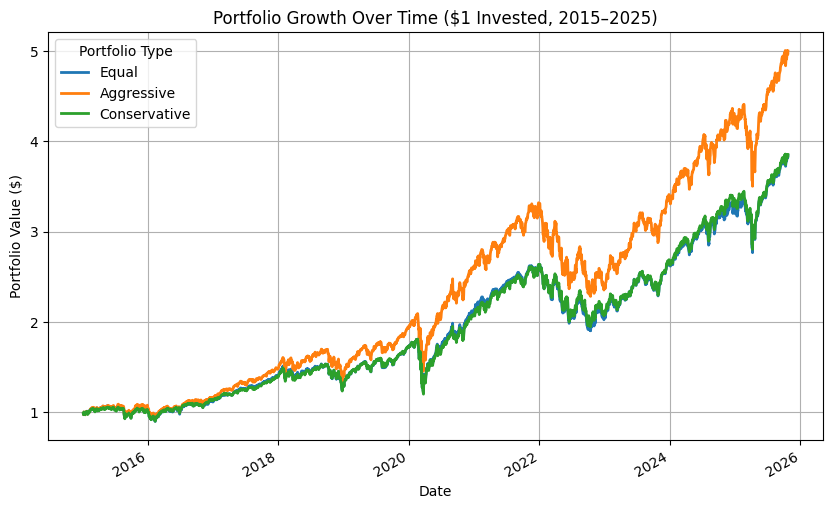

In [55]:
plt.figure(figsize=(10,6))
cumulative_growth.plot(ax=plt.gca(), linewidth=2)
plt.title("Portfolio Growth Over Time ($1 Invested, 2015–2025)")
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Date")
plt.grid(True)
plt.legend(title="Portfolio Type")
plt.show()


In [56]:
summary = pd.DataFrame({
    "Total Return": cumulative_growth.iloc[-1] - 1,
    "Annualized Volatility": portfolio_returns.std() * (252**0.5)
}).sort_values("Total Return", ascending=False)

summary.style.format({
    "Total Return": "{:.2%}",
    "Annualized Volatility": "{:.2%}"
})

,Total Return,Annualized Volatility
Aggressive,399.77%,19.82%
Conservative,285.09%,18.02%
Equal,284.19%,18.08%



An aggressive portfolio is riskier with higher volatility and more rewarding (highest total return).

Diversification works. Equal and Conservative portfolios gave almost identical long-term growth (~284%) but at lower volatility than the Aggressive one. That shows how adding stable and international exposure smooths risk without major performance loss.

Risk–Return Efficiency. The incremental 115% gain (from 285% to 400%) came with roughly +1.8% more volatility.

Compute the Sharpe ratio to see if that was “worth it.”

In [57]:
summary = pd.DataFrame({
    "Total Return": cumulative_growth.iloc[-1] - 1,
    "Annualized Volatility": portfolio_returns.std() * (252**0.5)
})
summary["Sharpe Ratio"] = summary["Total Return"] / summary["Annualized Volatility"]
summary.style.format({
    "Total Return": "{:.2%}",
    "Annualized Volatility": "{:.2%}",
    "Sharpe Ratio": "{:.2f}"
})


,Total Return,Annualized Volatility,Sharpe Ratio
Equal,284.19%,18.08%,15.72
Aggressive,399.77%,19.82%,20.17
Conservative,285.09%,18.02%,15.82


After verifying weight alignment, the Aggressive portfolio (60% QQQ) exhibited the highest total return (399.9%) and volatility (19.8%) over the 2015–2025 period.

This aligns with expectations, as technology-focused ETFs tend to outperform during bull markets but fluctuate more sharply.
The Equal and Conservative portfolios, which spread exposure across U.S. large-cap, total market, and international ETFs, produced similar total returns with lower volatility

These results illustrate the trade-off between return and risk, confirming that diversification can achieve nearly comparable growth with reduced volatility

### **Which ETFs perform best under different market conditions? (Crisis, Bull, Bear)**

### COVID-19:

In [58]:
#covid period slice
covid_crash = close_prices['2020-02-01':'2020-03-31']


In [59]:
#daily returns
returns_crash = covid_crash.pct_change().dropna()


In [60]:
#cumulative return and annual volatility
cum_return = (1 + returns_crash).prod() - 1
vol_crash = returns_crash.std() * (252**0.5)


Calculate drawdown which measures the percentage drop from the highest portfolio value to the lowest before it recovers

In [61]:
#max drawdown
rolling_max = covid_crash.cummax()
drawdown = (covid_crash - rolling_max) / rolling_max
max_drawdown = drawdown.min()

In [62]:
metrics_crash = pd.DataFrame({
    'Cumulative Return': cum_return,
    'Annualized Volatility': vol_crash,
    'Max Drawdown': max_drawdown
})

metrics_crash.style.format({
    'Cumulative Return': '{:.2%}',
    'Annualized Volatility': '{:.2%}',
    'Max Drawdown': '{:.2%}'
})

,Cumulative Return,Annualized Volatility,Max Drawdown
Ticker,,,
QQQ,-14.20%,68.09%,-28.56%
VEU,-21.10%,63.45%,-33.46%
VOO,-20.11%,70.91%,-33.99%
VTI,-21.47%,69.43%,-35.00%


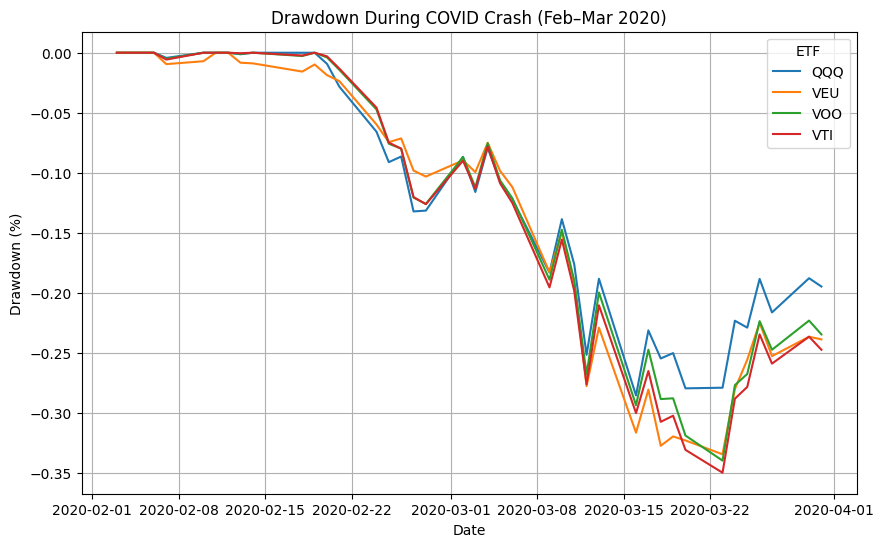

In [63]:
plt.figure(figsize=(10,6))
for ticker in covid_crash.columns:
    rolling_max = covid_crash[ticker].cummax()
    drawdown = (covid_crash[ticker] - rolling_max) / rolling_max
    plt.plot(drawdown, label=ticker)

plt.title('Drawdown During COVID Crash (Feb–Mar 2020)')
plt.ylabel('Drawdown (%)')
plt.xlabel('Date')
plt.legend(title='ETF')
plt.grid(True)
plt.show()

All four ETFs dropped ~30–35% highlighting how correlated global markets were during the COVID panic.

QQQ recovered first, showing perhaps how tech’s relative immunity to lockdowns (remote work, e-commerce, etc.) helped it rebound faster

VEU and VTI illustrate the drag from small caps and international exposure during global uncertainty

VOO stayed in between

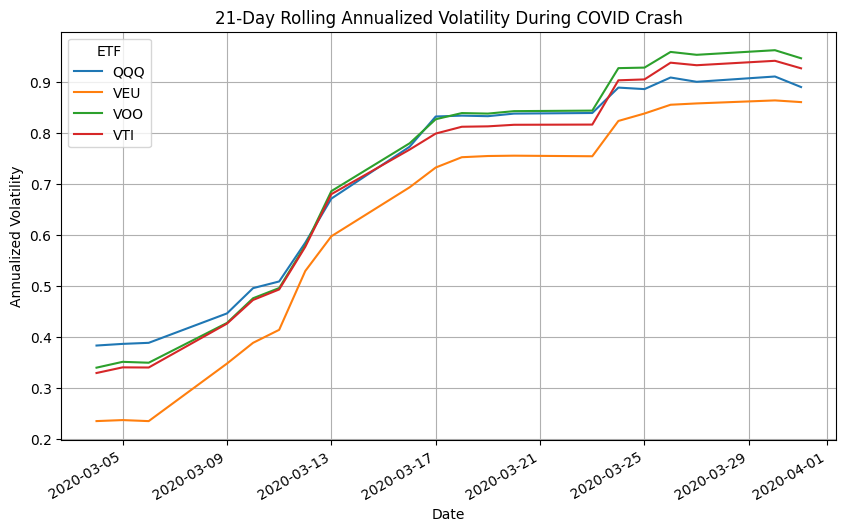

In [64]:
rolling_vol_crash = returns_crash.rolling(window=21).std() * (252**0.5)
rolling_vol_crash.plot(figsize=(10,6))

plt.title('21-Day Rolling Annualized Volatility During COVID Crash')
plt.ylabel('Annualized Volatility')
plt.xlabel('Date')
plt.legend(title='ETF')
plt.grid(True)
plt.show()

Volatility tripled in a few weeks — from ~30% to ~90%+ annualized.

What was most interesting was that volatility rose ahead of major drawdowns, showing how risk perception (panic) tends to spike before the deepest market declines

Cool insight: Volatility rose ahead of major drawdowns, showing how risk perception/panic tends to spike before the deepest market declines

### Interest Rate Hikes: Jan 2022 - Dec 2022

In [65]:
rate_hike_period = close_prices.loc['2022-01-01':'2022-12-31']
returns_rate_hike = rate_hike_period.pct_change().dropna()

In [66]:
cum_return_rate_hike = (1 + returns_rate_hike).prod() - 1
vol_rate_hike = returns_rate_hike.std() * (252**0.5)

rolling_max = rate_hike_period.cummax()
drawdown_rate_hike = (rate_hike_period - rolling_max) / rolling_max
max_drawdown_rate_hike = drawdown_rate_hike.min()

metrics_rate_hike = pd.DataFrame({
    'Cumulative Return': cum_return_rate_hike,
    'Annualized Volatility': vol_rate_hike,
    'Max Drawdown': max_drawdown_rate_hike
}).style.format('{:.2%}')
metrics_rate_hike

,Cumulative Return,Annualized Volatility,Max Drawdown
Ticker,,,
QQQ,-33.22%,32.20%,-34.83%
VEU,-16.13%,21.40%,-28.27%
VOO,-18.67%,24.21%,-24.52%
VTI,-20.03%,24.93%,-25.36%


<Figure size 1200x600 with 0 Axes>

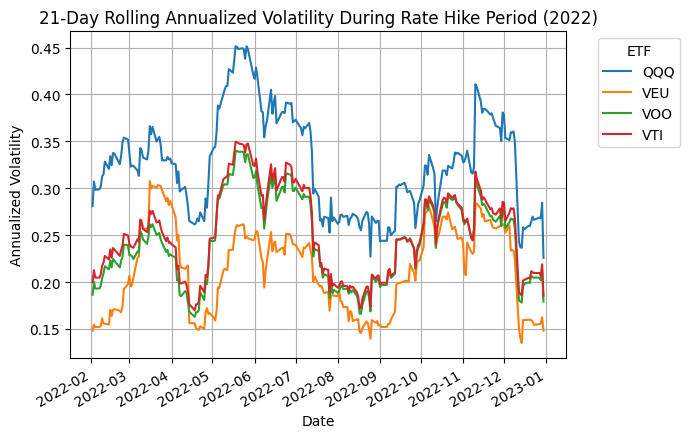

In [67]:
rolling_vol_rate_hike = returns_rate_hike.rolling(window=21).std() * (252**0.5)
plt.figure(figsize=(12,6))
rolling_vol_rate_hike.plot()
plt.title('21-Day Rolling Annualized Volatility During Rate Hike Period (2022)')
plt.ylabel('Annualized Volatility')
plt.xlabel('Date')
plt.legend(title='ETF',bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

Unlike COVID (a short, violent shock), volatility in 2022 was persistent but moderate, reflecting ongoing uncertainty as inflation and rate expectations evolved.

Peaks around June 2022 and October 2022 align with major Fed hike announcements and CPI releases.

QQQ, dominated by long-duration growth stocks, consistently exhibited higher volatility

In contrast, VOO and VTI displayed steadier volatility levels, reflecting the resilience of diversified U.S. exposure, while VEU’s lower volatility suggested relative insulation from U.S. rate dynamics

### Rate cuts 2023-2024 which is fed slowing hikes and then signaling cuts

In [68]:
rate_cut_period = close_prices.loc['2023-01-01':'2024-12-31']
returns_rate_cut = rate_cut_period.pct_change().dropna()

In [69]:
#21 day rolling volatility
rolling_vol_rate_cut = returns_rate_cut.rolling(window=21).std() * (252**0.5)

<Figure size 1000x600 with 0 Axes>

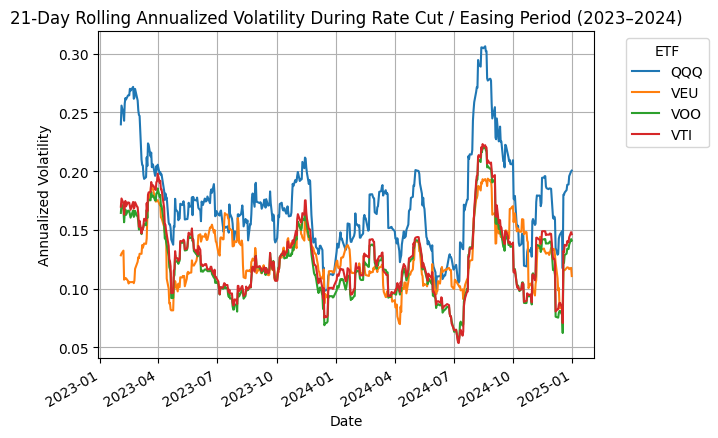

In [70]:
plt.figure(figsize=(10,6))
rolling_vol_rate_cut.plot()
plt.title('21-Day Rolling Annualized Volatility During Rate Cut / Easing Period (2023–2024)')
plt.ylabel('Annualized Volatility')
plt.xlabel('Date')
plt.legend(title='ETF', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


Overall volatility is the lowest of all three periods. markets calmer during easing

QQQ still leads volatility, but its baseline is much lower (≈0.15–0.20 vs 0.40 in 2022)


### **Bar graph comparing rolling volatilities of 3 periods**

In [71]:
# 21-day rolling annualized volatility for 3 periods
rolling_vol_covid = returns_crash.rolling(window=21).std() * (252**0.5)
rolling_vol_rate_hike = returns_rate_hike.rolling(window=21).std() * (252**0.5)
rolling_vol_rate_cut = returns_rate_cut.rolling(window=21).std() * (252**0.5)

# Average volatility during each period
avg_vol_covid = rolling_vol_covid.mean()
avg_vol_rate_hike = rolling_vol_rate_hike.mean()
avg_vol_rate_cut = rolling_vol_rate_cut.mean()

# Combine into one DataFrame
avg_vol_comparison = pd.DataFrame({
    'COVID Crash (2020)': avg_vol_covid,
    'Rate Hike (2022)': avg_vol_rate_hike,
    'Rate Cut (2023–2024)': rolling_vol_rate_cut.mean()
})
avg_vol_comparison

,COVID Crash (2020),Rate Hike (2022),Rate Cut (2023–2024)
Ticker,,,
QQQ,0.709499,0.325141,0.173868
VEU,0.625796,0.213949,0.127134
VOO,0.717133,0.244054,0.122998
VTI,0.701014,0.251264,0.126809


Plot bar graph

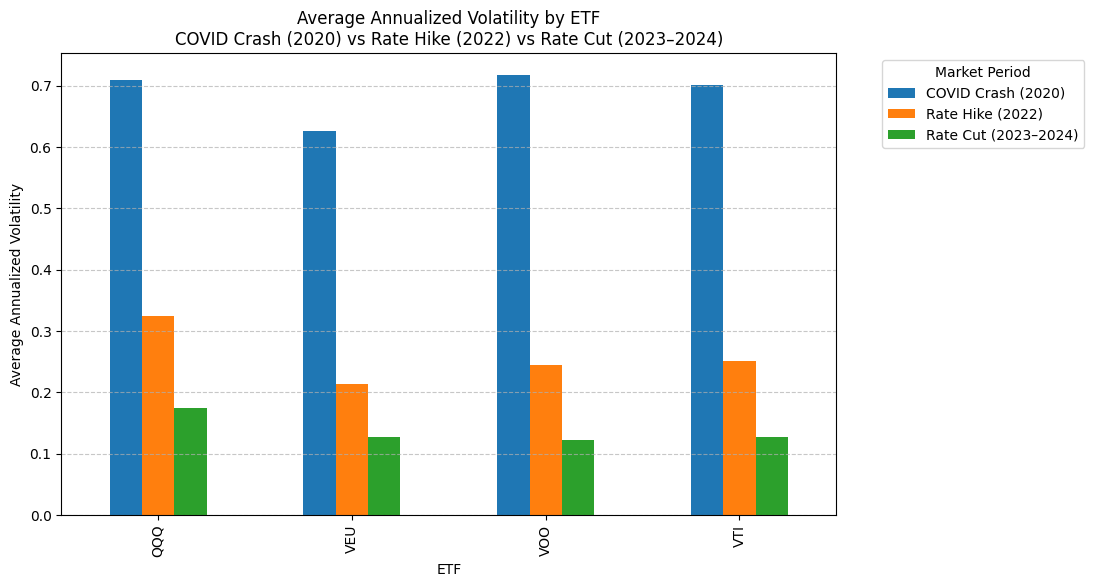

In [72]:
avg_vol_comparison.plot(kind='bar', figsize=(10,6))
plt.title('Average Annualized Volatility by ETF\nCOVID Crash (2020) vs Rate Hike (2022) vs Rate Cut (2023–2024)')
plt.ylabel('Average Annualized Volatility')
plt.xlabel('ETF')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Market Period', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Each bar represents the average short-term (21-day) annualized volatility of each ETF during three major macro periods.
It visualizes how market stability evolved across the last few years.

QQQ is the most sensitive to macro cycles tech volatility more than halved as rates fell.

VEU International markets showed smoother transitions, less extreme swings overall.

